In [171]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyreadr


In [172]:
# Set the float_format parameter to display real numbers without scientific notation
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [173]:
os.chdir("C:\\Users\\qaedi\\Documents\\")

In [176]:
# load datasets needed for proccesing
intg = pd.read_csv("interg_tes.tsv.gz", sep="\t", index_col=0) # This is the manin matrix and coming from intergenicMTX_maker.py 
# annotation data
rmsk_int=pd.read_csv("te_intergenic_rmsk.tsv", sep="\t")
column_names = ['Name', 'LociNumber', 'RepName', 'RepClass', 'repFamily', 'LocusType', "Coordinates"]
rmsk_int.columns = column_names

# id map
id_map=pyreadr.read_r("id_map.RDS")
id_map=pd.DataFrame(id_map[None])
# create a new column in id_map for mapping between sf file names and barcode
id_map['sf_fname'] = id_map['file_name'].apply(lambda x: x.replace('.bam', '.sf'))

Summary of TE counts:
count   326160.0000000000
mean        97.8369131888
std       1896.6365451730
min          0.0000000140
25%          3.0000000000
50%          8.0000000000
75%         26.0000000000
max     710227.1681000001
Name: count, dtype: float64


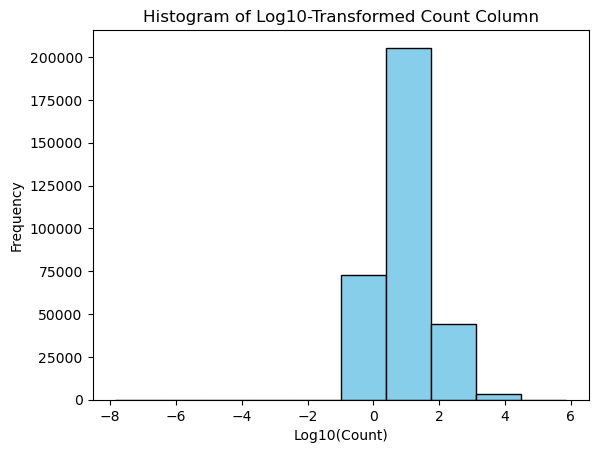

In [181]:
# Summary stat
# elements with lociNumber > count in the whole cohort should be dropped
dat = pd.DataFrame({'Name': intg.index,'count': intg.sum(axis=1)
})
print("Summary of TE counts:")
print(dat['count'].describe())

# Transform 'count' values to log10
log_count= np.log10(dat['count'])

# Create a histogram of the log-transformed 'count' column
plt.hist(log_count, bins=10, color='skyblue', edgecolor='black')

# Add labels and a title
plt.xlabel('Log10(Count)')
plt.ylabel('Frequency')
plt.title('Histogram of Log10-Transformed Count Column')

# Show the histogram
plt.show()

In [182]:
# prepare datasets

dat_merged = pd.merge(dat, rmsk_int, on='Name', how='left')

# Split the 'Coordinates' column and explode it into multiple rows
dat_merged['Coordinates'] = dat_merged['Coordinates'].str.split(',')
dat_merged = dat_merged.explode('Coordinates')

# craetea uique name out of loci and names
dat_merged['unique_name']= dat_merged['RepName']+ "|" +  dat_merged['repFamily']+ "|" +  dat_merged['RepClass']+ "|" + dat_merged['Coordinates']
# to drop names 
to_drop = list(set(dat_merged[dat_merged['LociNumber'] > dat_merged['count']].iloc[:, 0]))
oneLoci_names = list(set(dat_merged[dat_merged['LociNumber'] == 1].iloc[:, 0]))
mLoci_names = list(set(dat_merged[dat_merged['LociNumber'] > 1].iloc[:, 0]))

#### Rules to process files

1. TEs with number of loci > sum of count in all samples, are dropped
2. For multi loci TEs, read counts are divided by the loci number

In [189]:
# Start processing 

# to drop indexes in to_drop
intg_lowCount_dropped=intg[~intg.index.isin(to_drop)]
# subset for lociNumber 1
oneL = intg_lowCount_dropped[intg_lowCount_dropped.index.isin(oneLoci_names)]
# subset for lociNumber > 1
unprocessed_mLoci = intg_lowCount_dropped[intg_lowCount_dropped.index.isin(mLoci_names)]


In [190]:
# processing one locus elements

# Create a mapping dictionary from 'Name' to 'unique_name'
row_mapping_dict = dict(zip(dat_merged['Name'], dat_merged['unique_name']))
col_mapping_dict = dict(zip(id_map['sf_fname'], id_map['cases']))
# Maping 
oneL.index = oneL.index.map(row_mapping_dict)
oneL.columns = oneL.columns.map(col_mapping_dict)


In [195]:
# multi loci processing

mLoci_merged = pd.merge(unprocessed_mLoci, dat_merged, left_index=True, right_on='Name', how='left')
# Convert the relevant columns to numeric types
mLoci_merged ['LociNumber'] = pd.to_numeric(mLoci_merged ['LociNumber'], errors='coerce')
mLoci_merged.iloc[:, [0, mLoci.shape[1]]] = mLoci_merged.iloc[:, [0, mLoci.shape[1]]].apply(pd.to_numeric, errors='coerce')

# Perform the division
mLoci_merged.iloc[:, [0, mLoci.shape[1]]] = mLoci_merged.iloc[:, [0, mLoci.shape[1]]].div(mLoci_merged['LociNumber'], axis=0)
# reset index
mLoci_merged.set_index('unique_name', inplace=True)
# Set the name of the index to None
mLoci_merged.index.name = None
# subset
mLoci = mLoci_merged[unprocessed_mLoci.columns.tolist()]
# mapping column names
mLoci.columns = mLoci.columns.map(col_mapping_dict)


In [199]:
# Saving the result
# Concatenate mLoci to oneL without ignoring indices
result_df = pd.concat([oneL, mLoci], ignore_index=False)

# Write the resulting DataFrame to a CSV file in gz format
result_df.to_csv('RE_intergenic_4_loci_raw_counts', compression='gzip')